In the past, I've done some models using several libraries in Python without really understanding what I was doing. I want to implement multiple learning models, using less -or **none**- *pre-made* ML resources. I hope this will be reflected in a  deeper understanding on what each learning model does.

This time, I'll be implementing **Linear regression** in Python.

I'll be using `pandas` to import and process data sets, `numpy` to get useful linear algebra functions, and `pyplot`, `seaborn` to make **really cute** graphics. Just take a look. Yeah... they're cute, aren't they?

## First, let's load our libraries.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
# import dataframe
df = pd.read_csv('../input/kc_house_data.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

## Create prediction target and feature matrix

In [3]:
df.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

By looking at column names, I can say that `'id'` and `'price'` will conform `'y'`, my prediction target.

I'm pretty skeptical that `'date'`, `'zipcode'`, `'lat'`,  or `'long'` are correlated to the price of the house. But I'll decide that later. For now, I'll assume everything **could** influence `'price'`, so `X`, my feature matrix, will be conformed by the whole dataframe, without `'id'` and `'price'`.

Let's create those matrices:

In [4]:
pred_target = ['id', 'price']
y = df[pred_target]    # 'y' only has 'pred_target[]' features
# delete 'pred_target[]' features from original df, and assign it to X.
    # it doesn't happen 'inplace'. df isn't modified
X = df.drop(pred_target, axis=1)

### Find Correlations

Before trying to find correlations between `X` and `y['price']`, I'll update `'date'`. 

In the original dataframe, date was a string. I converted it to datetime, and now I'll convert it to days (elapsed since the lowest value of the whole column). So, if I find any correlation, It will be able to work with.

In [5]:
# Convert datetime to integer in 'date'
X['date'] =  (X['date'] - X['date'].min())  / np.timedelta64(1,'D')

Now, let's go and calculate the correlation ratio between `X` and `'price'`

In [6]:
corr = X.corrwith(y['price'])
corr = corr.to_frame().transpose().rename({0:'price'})
corr

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,-0.004357,0.30835,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447


That's useful... but I want something **fancier**. Something you would like to look at. Let's do a heatmap of it.

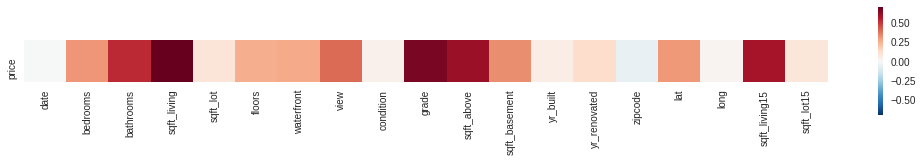

In [7]:
fig, ax = plt.subplots(figsize=(18,2))
sns.heatmap(corr, square = True);

That's better. -*It kinda looks like an skinometer, doesn't it?*-.

Now we can decide which features actually influence house price.

| Correlation ratio 	| Features 	|
|-------------------	|----------	|
|       >= .5       	|   **sqft_living** (0.702035), ** sqft_above** (0.605567),  **bathrooms** (0.525138), **grade** (0.667434)	|
|     <.5 , >= 4    	|          	|
|     <.3, >= 3     	|          	|

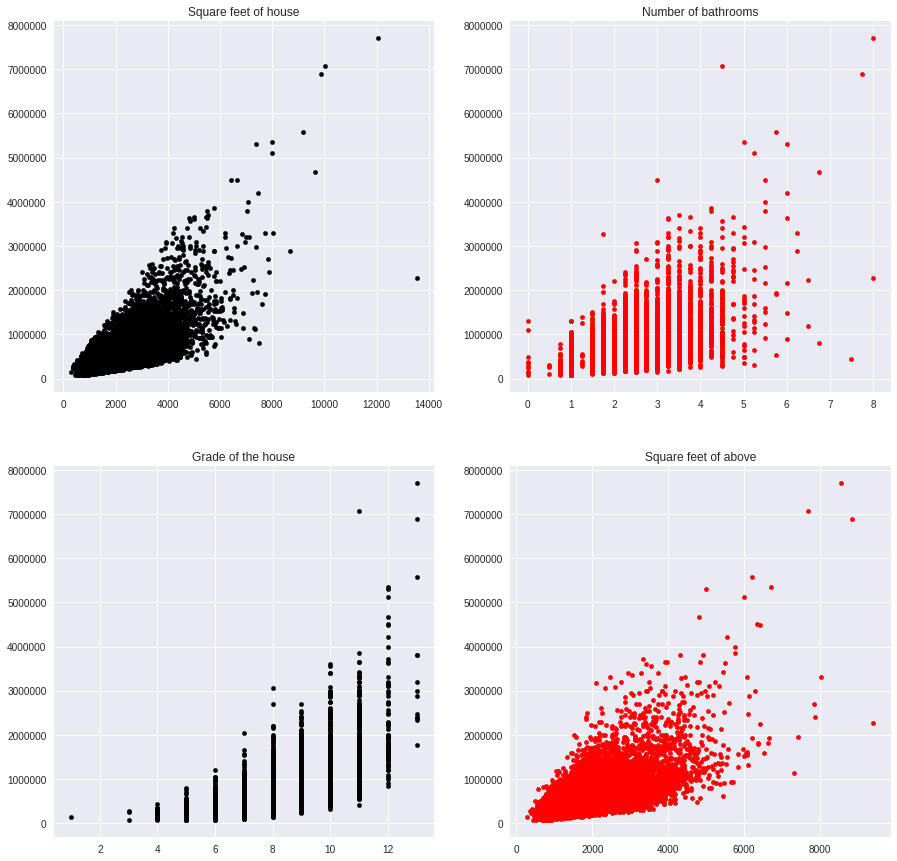

In [8]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2, figsize = (15,15) )
axarr[0, 0].scatter(X['sqft_living'], y['price'], alpha = 1, s = 20, c = "black");
axarr[0, 0].set_title('Square feet of house')
axarr[0, 1].scatter(X['bathrooms'], y['price'], alpha = 1, s = 20, c = "red");
axarr[0, 1].set_title('Number of bathrooms')
axarr[1, 0].scatter(X['grade'], y['price'], alpha = 1, s = 20, c = "black");
axarr[1, 0].set_title('Grade of the house')
axarr[1, 1].scatter(X['sqft_above'], y['price'], alpha = 1, s = 20, c = "red");
axarr[1, 1].set_title('Square feet of above');

#### =======IGNOREEE===========
(Will convert py code to md to avoid unnecesary processing) (Work in progress)

To normalize, we implement the mathematical model into a python function

$$
x_{i}:=\dfrac{x_{i}−\mu_{i}}{s_{i}}
$$

# X is the feature matrix, and a the array of the features to be normalized
def normalize(X, arr):
    X_norm = X[:]    # copy feature matrix
    mu = []          # median matrix
    sigma = []       # std matrix
    for i in range(len(arr)):
        mu.append(X_norm.iloc[:,arr[i]].mean())        # append median of (arr[i]th) column
        sigma.append(X_norm.iloc[:,arr[i]].std())      # append std of (arr[i]th)column
        # normalize (arr[i]th) column
        X_norm.iloc[:,arr[i]] = (X_norm.iloc[:,arr[i]] - mu[i]) / sigma[i]
    return mu, sigma, X_norm

# mu list contains median of all normalized columns
# sigma list contains std of all normalized columns
# X_norm is X matrix normalized
[mu, sigma, X_norm] = normalize(X, toNormalize)
X_norm

Now we modify X_norm, adding the intercept term.

X_norm['temp'] = 1
X_norm.insert(0, 'intercept', X_norm['temp'])
X_norm.pop('temp')
X_norm

Now, let's stablish the learning rate `alpha`, `num_iters`, and theta vector.

X_norm.pop('date')
alpha = .000000000001
num_iters = 5000
theta = [0] * len(X_norm.columns)

def computeCost(X, y, theta):
    return (X_norm.dot(theta)).subtract(y.iloc[:,0]).pow(2).sum() / (2 * len(y))

def gradientDescent(X_sample, y_sample, theta_sample, alpha, num_iters):
    m = len(y)
    J_history = []
    for i in range(num_iters):
        error = (X_sample.dot(theta)).subtract(y_sample.iloc[:,0]);
        for j in range(len(theta_sample)):
            if (m == 0):
                print("pendejo")
            else:
                theta_sample[j] = theta_sample[j]-(alpha * error.multiply(X_sample.iloc[:,j]).sum())/m;

        J_history.append(computeCost(X_sample, y_sample, theta_sample));
        if ((i>1) and J_history[i-1] - J_history[i] < .001):
            print ("HAHA")
            return theta, J_history
    return theta, J_history

alpha = .0000000002
theta = [0] * len(X_norm.columns)
[theta, J_history] = gradientDescent(X_norm,y, theta, alpha,500)
# print(J_history)
# print(y_sample)

# X_sample = X_norm.iloc[0:20,:]
# y_sample = y.iloc[0:20,:]
# [0] * len(X_sample.columns)

plt.plot(J_history)

ids = [3271300955,9830200380,4385700735,4385700765,1776460190,4040800360,9828700005,3024079063,
       6430500293,293910070,3449900030,7308900490,7852020250,3630200460,3425059141,259800410,
       6928600330,3905040070,2922701085,7974200777,6699300330,1118001360,1330850130,6880200030,
       4458300190,1771100440,8143100500,7424600020,9573120260,7853340330,34001304,1524079156,
       5430300171,1702901500,3751601501,5418650080,2770601800,1523049115,1509700050,8731960050,
       5146000070,5021900090,7550801206,3663500060,11200290,9474700020,616000140,722059020,
       8682220150,2922701175,9267200226,8658300315,1782000180,1221039058,461003835,8864000970,
       4222700130,1972202023,2725069164,4363700200,6431000749,7625702616,1771110720,8731951370,
       2473480560,7893800534,1561900180,3298700941,6713100031,7137900320,3205100080,4345000490,
       9558021010,724069070,3124049171,7839300185,5009600010,1922069099,8137500400,7582700075,
       9250900104,4178300040,3904920390,4305200070,7419500200,4157600120,7853321090,6021502300,
       7844200040,2968801130,1498303905,3383900048,5592900020,7519000585,1102000514,375000165,
       9165100375,8091400200,7985000010,3583300135]

results = pd.DataFrame()
for i in ids:
    ID = df.index[df['id'] == i].tolist()[0]
    temp = pd.DataFrame([[df.iloc[ID,0], df.iloc[ID,1], X_norm.iloc[ID,:].dot(theta)]], columns=['id', 'real', 'predicted'])
    results = results.append(temp, ignore_index=True)

results

plt.plot(X_norm.dot(theta))